In [1]:
import numpy as np
import torch
from kitti.kitti_dataset import KittiDataset
import yaml
from easydict import EasyDict
from pathlib import Path
%matplotlib inline

In [2]:
cfg_path = Path("../kitti/cfg/kitti_dataset.yaml")
with open(cfg_path, "rb") as f:
    cfg = EasyDict(yaml.load(f))
dataset = KittiDataset(cfg, ["Car"])

<ipython-input-2-892357587d32>:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg = EasyDict(yaml.load(f))


# Visualize Data

In [3]:
from basic.utils.vis_utils import VisualWindow
from kitti.io.kitti_io import KittiIo
import matplotlib.pyplot as plt
test_idx = 77

In [4]:
test_data = dataset[test_idx]
kitti_reader = KittiIo(Path(cfg.DATA_PATH) / "training")
idx = test_data['frame_id']
calib = kitti_reader.read_calibration(idx)
gt_boxes = test_data['gt_boxes']
print(f"test frame_id:{idx}")

test frame_id:006155


In [5]:
anno = kitti_reader.read_label(idx)
for a in anno:
    print(a.cls_type, end=" ")
    print(a.box2d)
boxes2d = [a.box2d for a in anno]

Car [680.22 189.59 800.   275.75]
Car [487.42 189.01 531.91 217.99]
Car [345.08 195.9  454.41 265.14]
Car [404.36 191.66 486.31 243.51]
Car [ 62.   211.17 340.29 341.36]
DontCare [527.27 181.27 578.35 196.94]
DontCare [581.6  179.28 618.16 189.9 ]
DontCare [625.19 177.1  674.19 193.81]


### 图像画框

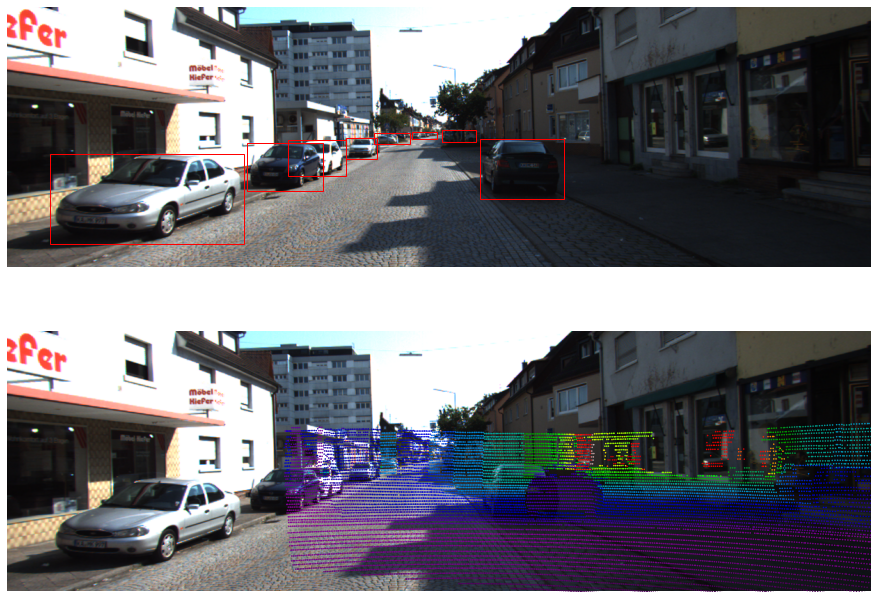

In [6]:
# 图像画框
raw_pc = kitti_reader.read_velodyne_bin(idx)
pc = test_data['points']
img = kitti_reader.read_image(idx)
img_shape = list(img.shape)
img_window = VisualWindow(mode='top_bot', img_shape=img_shape)
# 画图
img_window.draw_img(img)
# 画box2d
img_window.draw_boxes2d_on_img(boxes2d)
# 画点云投影
img_window.draw_point_cloud_on_img(pc[:, :3], calib)
# img_window.draw_point_cloud_in_img(raw_pc[:, :3], calib)

### 俯视图BEV画框

In [7]:
# 原始点云
raw_pc = kitti_reader.read_velodyne_bin(idx)
# 预处理后的点云，点云坐标系
pc = test_data['points']
# Camera Coordinate
pc_cam = calib.points_lidar_to_camera(pc[:, :3])
# Pixel Coordinate
pts_img, pts_cam_depth = calib.points_lidar_to_pixel(pc[:, :3])
pc_img = np.concatenate((pts_img, pts_cam_depth[:, np.newaxis]), axis=-1)
pc_cam

array([[-2.9213517 ,  0.25837237, 11.160494  ],
       [ 5.497313  ,  1.6749597 ,  4.798512  ],
       [-1.5007429 ,  1.4106326 , 13.321672  ],
       ...,
       [12.173745  , -0.71756303,  7.3348665 ],
       [ 4.7151904 ,  1.6203927 , 14.210579  ],
       [ 5.432872  ,  0.7916729 , 30.014885  ]], dtype=float32)

In [8]:
pc_img

array([[ 424.6057   ,  189.5308   ,   11.160494 ],
       [1444.6951   ,  424.5148   ,    4.798512 ],
       [ 531.5327   ,  249.22255  ,   13.321672 ],
       ...,
       [1812.5391   ,  102.25787  ,    7.3348665],
       [ 851.9637   ,  255.09488  ,   14.210579 ],
       [ 741.58856  ,  191.87492  ,   30.014885 ]], dtype=float32)

#### 2d散点图表示

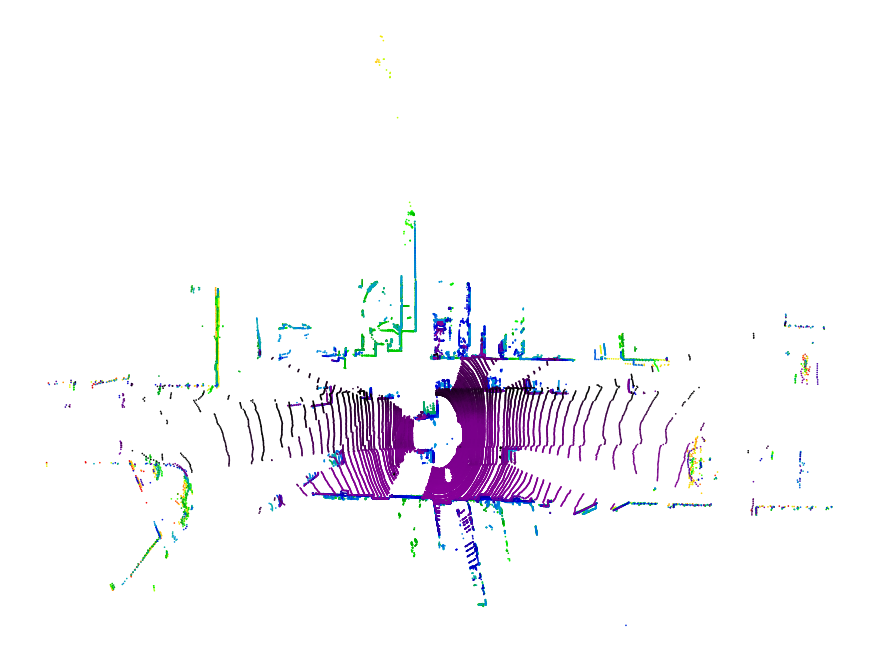

In [9]:
bev_window = VisualWindow(mode='bev')
bev_window.draw_bev(raw_pc, is_img=False, pc_in_point_coord=True, depth_range=[-2, 5])

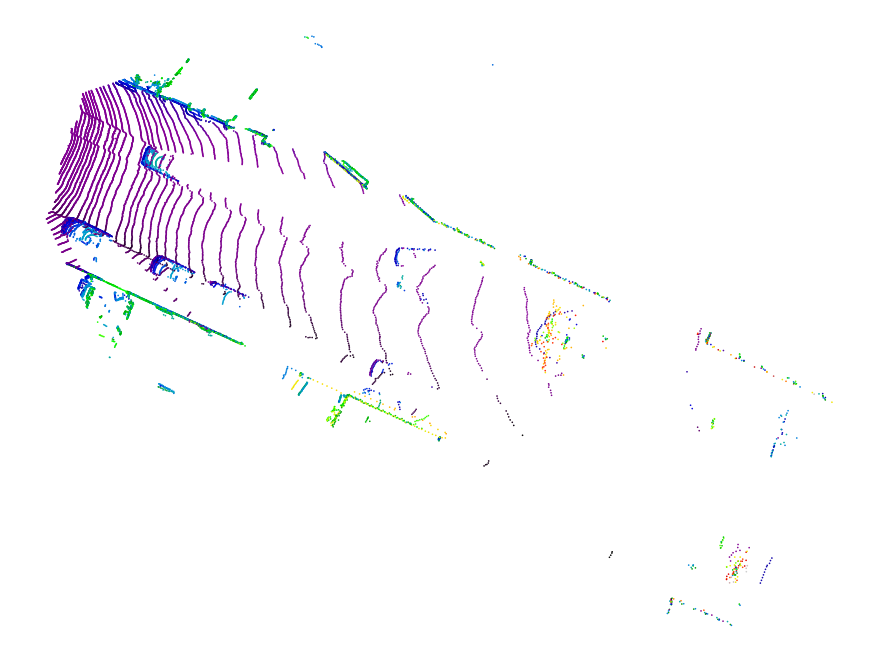

In [10]:
bev_window = VisualWindow(mode='bev')
bev_window.draw_bev(pc, is_img=False, pc_in_point_coord=True, depth_range=[-2, 5])

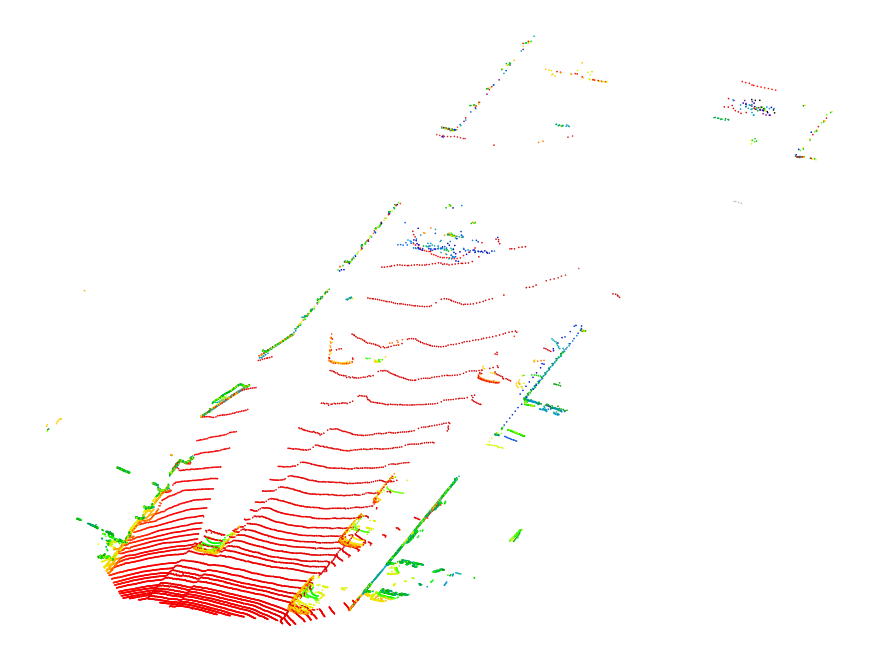

In [11]:
bev_window = VisualWindow(mode='bev')
bev_window.draw_bev(pc_cam, is_img=False, pc_in_point_coord=False)

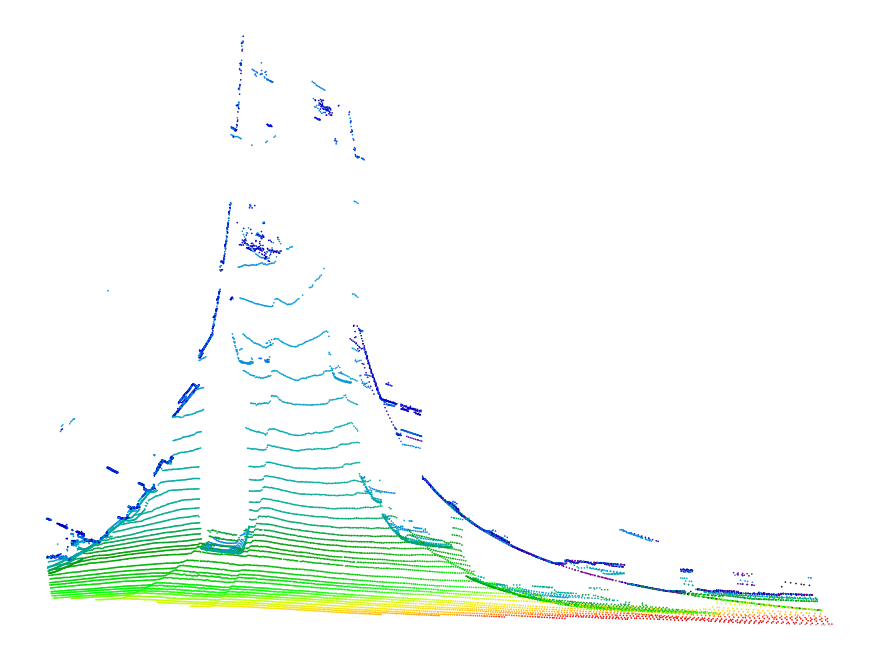

In [12]:
bev_window = VisualWindow(mode='bev')
bev_window.draw_bev(pc_img, is_img=False, pc_in_point_coord=False)

#### 图像表示

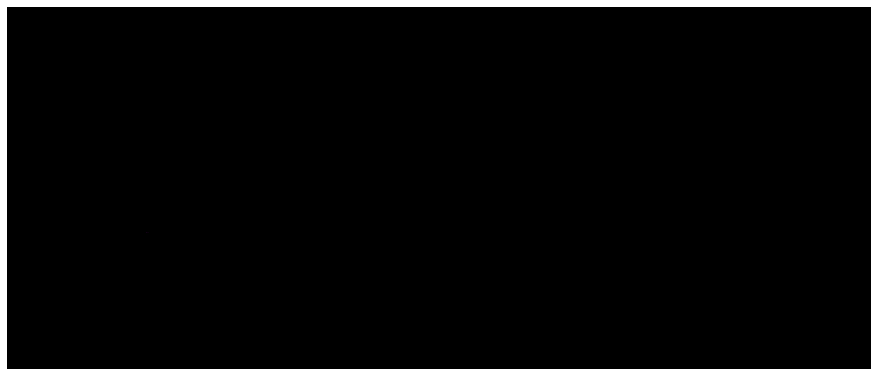

In [13]:
from basic.utils.vis_utils import convert_bev_point2img
bev_window = VisualWindow(mode='bev')
bev_img = convert_bev_point2img(raw_pc, res=0.1, coordinate='Point')
bev_window.bev_axes.set_ylim(0, bev_img.shape[0])
bev_window.draw_bev(bev_img, is_img=True)

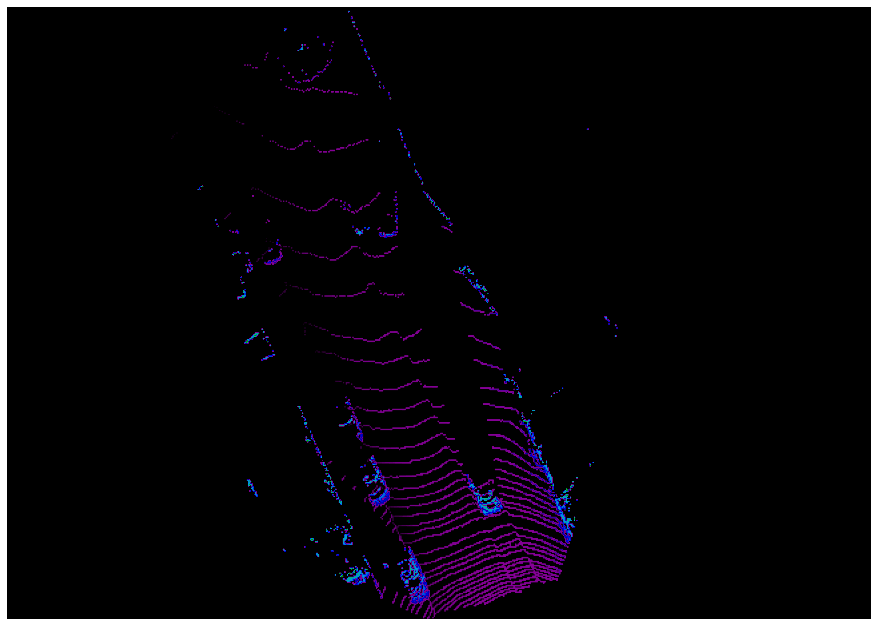

In [14]:
bev_window = VisualWindow(mode='bev')
bev_img = convert_bev_point2img(pc, res=0.1, coordinate='Point')
bev_window.bev_axes.set_ylim(0, bev_img.shape[0])
bev_window.draw_bev(bev_img)

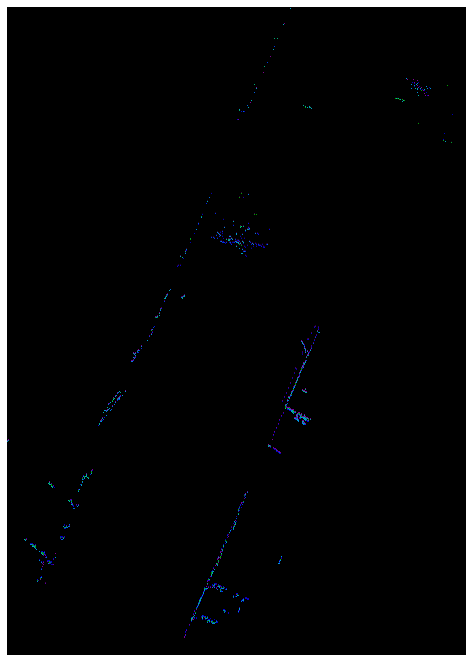

In [15]:
bev_window = VisualWindow(mode='bev')
bev_img = convert_bev_point2img(pc_cam, res=0.1,cam_off=None,coordinate='Camera')
bev_window.bev_axes.set_ylim(0, bev_img.shape[0])
bev_window.draw_bev(bev_img)

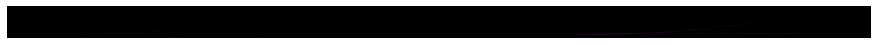

In [16]:
bev_window = VisualWindow(mode='bev')
bev_img = convert_bev_point2img(pc_img, res=0.1,cam_off=[calib.cu, calib.cv],coordinate='Pixel')
bev_window.bev_axes.set_ylim(0, bev_img.shape[0])
bev_window.draw_bev(bev_img)

# 3D点云画框

In [17]:
boxes3d = test_data['gt_boxes']
print("boxes3d shape:", boxes3d.shape)
boxes3d

boxes3d shape: (10, 8)


array([[ 1.3614054e+01, -3.5894308e+00, -9.7571737e-01,  3.5958025e+00,
         1.5642217e+00,  1.3448492e+00, -4.2764542e-01,  1.0000000e+00],
       [ 3.2396084e+01, -2.0113909e+01, -1.1814836e+00,  3.7865613e+00,
         1.6786770e+00,  1.3639250e+00,  2.7523546e+00,  1.0000000e+00],
       [ 1.4327861e+01, -1.1917188e+01, -1.1519122e+00,  3.7579474e+00,
         1.5356079e+00,  1.4211527e+00,  2.7323546e+00,  1.0000000e+00],
       [ 1.8777885e+01, -1.3928225e+01, -1.1148778e+00,  3.7197957e+00,
         1.5832976e+00,  1.4116148e+00,  2.7623546e+00,  1.0000000e+00],
       [ 7.1900587e+00, -9.0218744e+00, -1.1533512e+00,  4.0345478e+00,
         1.5069942e+00,  1.2494698e+00,  2.7423546e+00,  1.0000000e+00],
       [ 3.4379547e+01, -1.0908445e+01, -9.1270173e-01,  3.4431953e+00,
         1.5356079e+00,  1.4116148e+00,  3.1223545e+00,  1.0000000e+00],
       [ 1.2877980e+01, -2.1213732e+01, -5.7718444e-01,  2.9853747e+00,
         1.3353113e+00,  1.2208560e+00,  2.7123547e+00,  1

In [20]:
%matplotlib auto
window3d = VisualWindow(mode='3d')
window3d.draw_point_cloud(pc)
window3d.draw_boxes3d(boxes=boxes3d[:, :7], format='center')
plt.show()

Using matplotlib backend: Qt5Agg
